In [10]:
# ============================================
# 4개 predicate(Confirmshaming / Trick Questions / Pressured Selling / Activity Notifications)
# 유사도 & 분포 한방 분석 스크립트
# - TF-IDF(word 1~3-gram + char 3~5-gram)
# - Centroid 코사인/유클리드 + 히트맵
# - Intra/Inter 코사인 분포(히스토그램)
# - 거리(샘플↔자기 클래스 centroid) 분포(히스토그램/박스)
# - Silhouette 점수 분포(히스토그램)
# - 2D 임베딩(TruncatedSVD) 산점도
# - Centroid 덴드로그램(계층 군집)
# - (옵션) 샘플링 pairwise cosine 히트맵
# ============================================

import os, re, itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# ------------------ 설정 ------------------
FILE_PATH = "/Users/soyoung/404DNF_AI/data/processed/template_predicate.csv"      # 필요시 경로 변경
OUTPUT_DIR = "dp_dist"
os.makedirs(OUTPUT_DIR, exist_ok=True)

TARGET_PREDICATES = [
    "confirmshaming",
    "trick questions",
    "pressured selling",
    "activity notifications",
]

# ------------------ 1) 데이터 로드/필터 ------------------
df = pd.read_csv(FILE_PATH)
assert {"String", "predicate"} <= set(df.columns), "CSV에 String, predicate 컬럼이 필요합니다."
df = df.dropna(subset=["String", "predicate"]).copy()
df["predicate"] = df["predicate"].str.lower().str.strip()

mask = df["predicate"].isin([p.lower() for p in TARGET_PREDICATES])
data = df.loc[mask].reset_index(drop=True)
if data.empty:
    raise ValueError("선택한 predicate가 데이터에 없습니다.")

print("=== 클래스별 샘플 수 ===")
print(data["predicate"].value_counts(), "\n")

# ------------------ 2) 텍스트 정제 ------------------
def clean_keep_nums(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    # 숫자/%, $ 유지(가격/카운트류 신호 보존)
    s = re.sub(r"[^a-z0-9\s%$]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

data["text_clean"] = data["String"].astype(str).apply(clean_keep_nums)

# ------------------ 3) TF-IDF (word + char) ------------------
wvec = TfidfVectorizer(stop_words="english", ngram_range=(1,3), min_df=1, max_df=0.95, norm="l2")
cvec = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=2, norm="l2")
Xw = wvec.fit_transform(data["text_clean"])
Xc = cvec.fit_transform(data["text_clean"])
X  = hstack([Xw, Xc])  # csr_matrix

labels = data["predicate"].values
classes = sorted(pd.unique(labels))

# ------------------ 4) Centroid 유사도/거리 + 히트맵 ------------------
centroids = []
for c in classes:
    rows = X[labels == c]
    centroids.append(np.asarray(rows.mean(axis=0)).ravel())
centroids = np.vstack(centroids)

centroid_cos = cosine_similarity(centroids)
centroid_euc = euclidean_distances(centroids)

centroid_cos_df = pd.DataFrame(centroid_cos, index=classes, columns=classes)
centroid_euc_df = pd.DataFrame(centroid_euc, index=classes, columns=classes)
centroid_cos_df.to_csv(os.path.join(OUTPUT_DIR, "centroid_cosine.csv"))
centroid_euc_df.to_csv(os.path.join(OUTPUT_DIR, "centroid_euclidean.csv"))

def heatmap(mat, ticks, title, path):
    plt.figure(figsize=(6,5))
    im = plt.imshow(mat, interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(ticks)), ticks, rotation=45, ha="right")
    plt.yticks(range(len(ticks)), ticks)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()

heatmap(centroid_cos_df.values, classes, "Centroid Cosine Similarity", os.path.join(OUTPUT_DIR, "centroid_cosine_heatmap.png"))
heatmap(centroid_euc_df.values, classes, "Centroid Euclidean Distance", os.path.join(OUTPUT_DIR, "centroid_euclidean_heatmap.png"))

# ------------------ 5) Intra/Inter 분포(히스토그램) ------------------
# Intra: 같은 클래스 내 pairwise cosine
for c in classes:
    idx = np.where(labels == c)[0]
    if len(idx) < 2:
        continue
    sub = X[idx]
    S = cosine_similarity(sub)
    # 상삼각(대각 제외)만 취해 분포 생성
    triu = np.triu_indices_from(S, k=1)
    vals = S[triu]
    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=30)
    plt.title(f"Intra-class Cosine Distribution: {c}")
    plt.xlabel("cosine")
    plt.ylabel("count")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"intra_cosine_hist_{c.replace(' ','_')}.png"), dpi=150)
    plt.close()

# Inter: 서로 다른 클래스 간 pairwise cosine
for a, b in itertools.combinations(classes, 2):
    Sa = X[labels == a]; Sb = X[labels == b]
    S = cosine_similarity(Sa, Sb).ravel()
    plt.figure(figsize=(6,4))
    plt.hist(S, bins=30)
    plt.title(f"Inter-class Cosine Distribution: {a} vs {b}")
    plt.xlabel("cosine")
    plt.ylabel("count")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"inter_cosine_hist_{a.replace(' ','_')}__{b.replace(' ','_')}.png"), dpi=150)
    plt.close()

# ------------------ 6) 샘플↔자기 centroid 거리 분포 ------------------
# (1 - cosine(sample, class_centroid)) 히스토그램 + 박스
for c in classes:
    Xi = X[labels == c]
    ci = centroids[classes.index(c)].reshape(1,-1)
    d = 1 - cosine_similarity(Xi, ci).ravel()
    # 히스토그램
    plt.figure(figsize=(6,4))
    plt.hist(d, bins=30)
    plt.title(f"Distance to Own Centroid (1 - cosine): {c}")
    plt.xlabel("1 - cosine")
    plt.ylabel("count")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"dist_to_centroid_hist_{c.replace(' ','_')}.png"), dpi=150)
    plt.close()
    # 박스플롯
    plt.figure(figsize=(4,5))
    plt.boxplot(d, vert=True, labels=[c])
    plt.ylabel("1 - cosine")
    plt.title(f"Box: Dist to Own Centroid")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"dist_to_centroid_box_{c.replace(' ','_')}.png"), dpi=150)
    plt.close()

# ------------------ 7) Silhouette (cosine) 분포 ------------------
le = LabelEncoder(); y = le.fit_transform(labels)
sil = silhouette_score(X, y, metric="cosine")
print("Silhouette (cosine):", round(sil, 3))
s_each = silhouette_samples(X, y, metric="cosine")
plt.figure(figsize=(6,4))
plt.hist(s_each, bins=30)
plt.title("Silhouette Score Distribution (cosine)")
plt.xlabel("silhouette score")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "silhouette_hist.png"), dpi=150)
plt.close()

# ------------------ 8) 2D 임베딩 산점도 (TruncatedSVD) ------------------
svd = TruncatedSVD(n_components=2, random_state=42)
X2 = svd.fit_transform(X)
print("SVD explained variance ratio (2D sum):", svd.explained_variance_ratio_.sum().round(3))

plt.figure(figsize=(6,5))
for c in classes:
    m = (labels == c)
    plt.scatter(X2[m,0], X2[m,1], s=18, alpha=0.85, label=c)
plt.legend(loc="best", fontsize=8)
plt.title("TruncatedSVD (TF-IDF word+char, 2D)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "svd_tfidf_scatter.png"), dpi=150)
plt.close()

# ------------------ 9) Centroid 덴드로그램 ------------------
# 코사인 거리 = 1 - 코사인 유사도
D = 1 - centroid_cos_df.values
np.fill_diagonal(D, 0.0)
condensed = squareform(D, checks=False)
Z = linkage(condensed, method="average")
plt.figure(figsize=(6,4))
dendrogram(Z, labels=classes, orientation="top")
plt.title("Dendrogram of Class Centroids (cosine distance)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "centroid_dendrogram.png"), dpi=150)
plt.close()

# ------------------ 10) (옵션) 샘플링 pairwise cosine 히트맵 ------------------
S_PER_CLS = 25  # 클래스당 최대 샘플 수
idx_all = []
for c in classes:
    ids = np.where(labels == c)[0].tolist()
    np.random.shuffle(ids)
    idx_all.extend(ids[:S_PER_CLS])
X_samp = X[idx_all]; labs_samp = labels[idx_all]
S = cosine_similarity(X_samp)

plt.figure(figsize=(7,6))
im = plt.imshow(S, interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
ticks = range(len(idx_all))
plt.xticks(ticks, labs_samp, rotation=90)
plt.yticks(ticks, labs_samp)
plt.title(f"Pairwise Cosine (sampled up to {S_PER_CLS}/class)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "pairwise_cosine_sampled_heatmap.png"), dpi=150)
plt.close()

# ------------------ 11) 간단 분류 성능(참고) ------------------
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = LogisticRegression(max_iter=2000, solver="liblinear", multi_class="ovr")
clf.fit(X_tr, y_tr)
from sklearn.metrics import classification_report
print("\n=== Logistic Regression (OVR) on TF-IDF ===")
print(classification_report(y_te, clf.predict(X_te), target_names=classes))

print(f"\n완료! 결과 이미지/CSV는 '{OUTPUT_DIR}/' 폴더에 저장되었습니다.")


=== 클래스별 샘플 수 ===
predicate
activity notifications    499
confirmshaming            298
pressured selling         140
trick questions            62
Name: count, dtype: int64 



/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_1953/3613127512.py:152: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(d, vert=True, labels=[c])
/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_1953/3613127512.py:152: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(d, vert=True, labels=[c])
/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_1953/3613127512.py:152: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(d, vert=True, labels=[c])
/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_1953/3613127512.py:152: MatplotlibDeprecationWarning: The 'labels

Silhouette (cosine): 0.062
SVD explained variance ratio (2D sum): 0.076

=== Logistic Regression (OVR) on TF-IDF ===
                        precision    recall  f1-score   support

activity notifications       0.89      1.00      0.94       100
        confirmshaming       0.98      1.00      0.99        60
     pressured selling       1.00      0.71      0.83        28
       trick questions       1.00      0.58      0.74        12

              accuracy                           0.94       200
             macro avg       0.97      0.82      0.88       200
          weighted avg       0.94      0.94      0.93       200


완료! 결과 이미지/CSV는 'dp_dist/' 폴더에 저장되었습니다.


/Users/soyoung/404DNF_AI/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/soyoung/404DNF_AI/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


In [13]:
# ============================================
# SBERT 기반 4개 predicate 유사도/분포 분석 (올인원)
# 대상: confirmshaming / trick questions / pressured selling / activity notifications
# - SBERT 임베딩(all-MiniLM-L6-v2, 384D, fast)
# - Centroid 코사인 유사도/거리, Intra/Inter 코사인 분포
# - Silhouette(코사인) 지표, 2D 임베딩(UMAP→SVD fallback)
# - 대표 문장(centroid 근접 Top-K) 추출
# - 샘플링 pairwise cosine 히트맵
# 산출물: sb_out/ 폴더에 PNG/CSV/TXT 저장
# ============================================

import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

# ---------- 경로/모델 설정 ----------
FILE_PATH = "/Users/soyoung/404DNF_AI/data/processed/template_predicate.csv"   # 필요 시 절대경로로 변경: /mnt/data/paraphrase_predicate.csv
OUTPUT_DIR = "sb_out"; os.makedirs(OUTPUT_DIR, exist_ok=True)

TARGET_PREDICATES = [
    "confirmshaming",
    "trick questions",
    "pressured selling",
    "activity notifications",
]

MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
# 다국어 문장 섞여 있으면:
# MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

BATCH_SIZE = 64
TOPK_REPR = 20
SAMPLE_PER_CLASS_FOR_HEATMAP = 25

# ---------- 1) 데이터 로드/필터 ----------
df = pd.read_csv(FILE_PATH)
assert {"String","predicate"} <= set(df.columns), "CSV에 String, predicate 컬럼이 필요합니다."
df = df.dropna(subset=["String","predicate"]).copy()
df["predicate"] = df["predicate"].str.lower().str.strip()

mask = df["predicate"].isin([p.lower() for p in TARGET_PREDICATES])
data = df.loc[mask].reset_index(drop=True)
if data.empty:
    raise ValueError("선택한 predicate가 데이터에 없습니다.")

print("=== 클래스별 샘플 수 ===")
print(data["predicate"].value_counts(), "\n")

texts = data["String"].astype(str).tolist()
labels = data["predicate"].values
classes = sorted(pd.unique(labels))

# ---------- 2) SBERT 임베딩 ----------
print("Embedding with SBERT:", MODEL_NAME)
model = SentenceTransformer(MODEL_NAME)
emb = model.encode(
    texts,
    batch_size=BATCH_SIZE,
    normalize_embeddings=True,   # L2 정규화 -> 코사인 = 내적
    convert_to_numpy=True,
    show_progress_bar=True
)  # shape: [N, D], 각 벡터는 단위 벡터

# ---------- 3) 클래스 centroid 및 유사도 ----------
centroids = []
for c in classes:
    ci = emb[labels == c].mean(axis=0)
    # 평균 후 다시 정규화 (단위 벡터로)
    norm = np.linalg.norm(ci) + 1e-12
    centroids.append(ci / norm)
centroids = np.vstack(centroids)  # [C, D]

# centroid 코사인/거리
centroid_cos = centroids @ centroids.T  # 단위벡터 -> 코사인 = 내적
centroid_dist = 1 - centroid_cos

centroid_cos_df = pd.DataFrame(centroid_cos, index=classes, columns=classes)
centroid_cos_df.to_csv(os.path.join(OUTPUT_DIR, "centroid_cosine.csv"))
pd.DataFrame(centroid_dist, index=classes, columns=classes).to_csv(
    os.path.join(OUTPUT_DIR, "centroid_cosine_distance.csv")
)

def heatmap(mat, ticks, title, path):
    plt.figure(figsize=(6,5))
    im = plt.imshow(mat, interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(ticks)), ticks, rotation=45, ha="right")
    plt.yticks(range(len(ticks)), ticks)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=150); plt.close()

heatmap(centroid_cos, classes, "Centroid Cosine Similarity (SBERT)", os.path.join(OUTPUT_DIR, "centroid_cosine_heatmap.png"))
heatmap(centroid_dist, classes, "Centroid Cosine Distance (1-cos)", os.path.join(OUTPUT_DIR, "centroid_distance_heatmap.png"))

print("=== (요약) SBERT 기반 centroid 코사인 유사도 ===")
print(centroid_cos_df.round(3), "\n")

# ---------- 4) Intra/Inter 코사인 분포 ----------
# Intra: 같은 클래스 내 문장-문장 코사인 분포 (히스토그램)
for c in classes:
    idx = np.where(labels == c)[0]
    if len(idx) < 2: 
        continue
    S = cosine_similarity(emb[idx])
    iu = np.triu_indices_from(S, k=1)
    vals = S[iu]
    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=30)
    plt.title(f"Intra-class Cosine (SBERT): {c}")
    plt.xlabel("cosine"); plt.ylabel("count")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"intra_cosine_hist_{c.replace(' ','_')}.png"), dpi=150)
    plt.close()

# Inter: 서로 다른 클래스 간 문장-문장 코사인 분포 (히스토그램)
import itertools
for a, b in itertools.combinations(classes, 2):
    Sa = emb[labels == a]; Sb = emb[labels == b]
    sims = cosine_similarity(Sa, Sb).ravel()
    plt.figure(figsize=(6,4))
    plt.hist(sims, bins=30)
    plt.title(f"Inter-class Cosine (SBERT): {a} vs {b}")
    plt.xlabel("cosine"); plt.ylabel("count")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"inter_cosine_hist_{a.replace(' ','_')}__{b.replace(' ','_')}.png"), dpi=150)
    plt.close()

# ---------- 5) Silhouette (cosine) 전반 분리도 ----------
le = LabelEncoder(); y = le.fit_transform(labels)
sil = silhouette_score(emb, y, metric="cosine")
print("Silhouette (cosine):", round(sil, 3), "(~0.2↑ 꽤 분리, 0.4↑ 매우 잘 분리)\n")

# 분포 그림
s_each = silhouette_samples(emb, y, metric="cosine")
plt.figure(figsize=(6,4))
plt.hist(s_each, bins=30)
plt.title("Silhouette Score Distribution (cosine, SBERT)")
plt.xlabel("silhouette score"); plt.ylabel("count")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "silhouette_hist.png"), dpi=150)
plt.close()

# ---------- 6) 2D 임베딩 산점도 (UMAP → SVD fallback) ----------
def scatter_2d(X2, labels_str, title, path):
    plt.figure(figsize=(6,5))
    for c in classes:
        m = (labels_str == c)
        plt.scatter(X2[m,0], X2[m,1], s=18, alpha=0.85, label=c)
    plt.legend(loc="best", fontsize=8)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=150); plt.close()

try:
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42, metric="cosine")
    X2 = reducer.fit_transform(emb)
    scatter_2d(X2, labels, "UMAP (SBERT, cosine)", os.path.join(OUTPUT_DIR, "umap_scatter.png"))
    print("UMAP 2D 산점도 생성 완료.")
except Exception as e:
    print("UMAP 사용 불가(fallback to TruncatedSVD):", e)
    svd = TruncatedSVD(n_components=2, random_state=42)
    X2 = svd.fit_transform(emb)  # 단위벡터지만 SVD로 투영
    scatter_2d(X2, labels, "TruncatedSVD (SBERT)", os.path.join(OUTPUT_DIR, "svd_scatter.png"))
    print("SVD 2D 산점도 생성 완료.")

# ---------- 7) 샘플링 pairwise cosine 히트맵 ----------
np.random.seed(42)
idx_all = []
for c in classes:
    ids = np.where(labels == c)[0].tolist()
    np.random.shuffle(ids)
    idx_all.extend(ids[:SAMPLE_PER_CLASS_FOR_HEATMAP])
emb_s = emb[idx_all]; labs_s = labels[idx_all]
S = cosine_similarity(emb_s)

plt.figure(figsize=(7,6))
im = plt.imshow(S, interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
ticks = range(len(idx_all))
plt.xticks(ticks, labs_s, rotation=90)
plt.yticks(ticks, labs_s)
plt.title(f"Pairwise Cosine (SBERT, sampled up to {SAMPLE_PER_CLASS_FOR_HEATMAP}/class)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "pairwise_cosine_sampled_heatmap.png"), dpi=150)
plt.close()

# ---------- 8) 클래스별 대표 문장(centroid 근접 Top-K) ----------
with open(os.path.join(OUTPUT_DIR, "representative_examples.txt"), "w", encoding="utf-8") as f:
    for i, c in enumerate(classes):
        sim_to_c = emb[labels==c] @ centroids[i]  # 단위벡터 내적 = 코사인
        idx_local = np.argsort(-sim_to_c)[:TOPK_REPR]
        ex_texts = data.loc[labels==c, "String"].iloc[idx_local].tolist()
        f.write(f"[{c}] centroid-near examples (Top {TOPK_REPR})\n")
        for t in ex_texts:
            f.write("- " + str(t).replace("\n"," ") + "\n")
        f.write("\n")

print(f"완료! 결과는 '{OUTPUT_DIR}/' 폴더에 저장되었습니다.")
print("- centroid_cosine.csv / centroid_*_heatmap.png / centroid_cosine_distance.csv")
print("- intra_cosine_hist_*.png / inter_cosine_hist_*__*.png")
print("- silhouette_hist.png")
print("- umap_scatter.png (또는 svd_scatter.png)")
print("- pairwise_cosine_sampled_heatmap.png")
print("- representative_examples.txt")


=== 클래스별 샘플 수 ===
predicate
activity notifications    499
confirmshaming            298
pressured selling         140
trick questions            62
Name: count, dtype: int64 

Embedding with SBERT: sentence-transformers/all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

=== (요약) SBERT 기반 centroid 코사인 유사도 ===
                        activity notifications  confirmshaming  \
activity notifications                   1.000           0.312   
confirmshaming                           0.312           1.000   
pressured selling                        0.586           0.591   
trick questions                          0.497           0.552   

                        pressured selling  trick questions  
activity notifications              0.586            0.497  
confirmshaming                      0.591            0.552  
pressured selling                   1.000            0.836  
trick questions                     0.836            1.000   

Silhouette (cosine): 0.15 (~0.2↑ 꽤 분리, 0.4↑ 매우 잘 분리)

UMAP 사용 불가(fallback to TruncatedSVD): Numba needs NumPy 2.2 or less. Got NumPy 2.3.
SVD 2D 산점도 생성 완료.
완료! 결과는 'sb_out/' 폴더에 저장되었습니다.
- centroid_cosine.csv / centroid_*_heatmap.png / centroid_cosine_distance.csv
- intra_cosine_hist_*.png / inter_cosine_hist_*__*.png
- s

기본 설정

In [2]:
# %% [markdown]
# 설치 (필요시 한 번만)
# !pip install pandas numpy scikit-learn matplotlib

# %% 
from pathlib import Path
import math, re, unicodedata
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA


경로/하이퍼파라미터

In [3]:
# %%
# 🔧 여기만 바꿔서 사용하세요
DATA_CSV = "/Users/soyoung/404DNF_AI/data/processed/template_predicate.csv"
OUT_DIR  = "/Users/soyoung/404DNF_AI/output/similarity"  # 저장 폴더

# 유사군집 임계값 (조절 가능)
PRED_THRESH   = 0.90  # predicate 내부 묶기
GLOBAL_THRESH = 0.92  # 전 predicate 묶기

# TF-IDF 옵션
ANALYZER   = "char"   # "char" or "word"
NGRAM_LO   = 3
NGRAM_HI   = 5
MIN_DF     = 1

# 히스토그램 쌍이 너무 많을 때 샘플링(0은 전체 사용)
MAX_PAIRS_FOR_HIST = 0  

out_dir = Path(OUT_DIR)
out_dir.mkdir(parents=True, exist_ok=True)

print("DATA_CSV:", DATA_CSV)
print("OUT_DIR :", out_dir.resolve())

FOCUS_PREDS = ["Confirmshaming", "Trick Questions", "Pressured Selling", "Activity Notifications"]

DATA_CSV: /Users/soyoung/404DNF_AI/data/processed/template_predicate.csv
OUT_DIR : /Users/soyoung/404DNF_AI/output/similarity


정규화 & 클러스터 함수

In [4]:
# %%
_num_re     = re.compile(r"\d+([.,]\d+)?")
_space_re   = re.compile(r"\s+")
_punct_re   = re.compile(r"[^\w\s<>\-]")  # 단어/숫자/공백/<>/-만 남김

def strip_emojis(s: str) -> str:
    if not isinstance(s, str):
        return ""
    return "".join(ch for ch in s if ch.isascii() or unicodedata.category(ch)[0] != "So")

def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = strip_emojis(s).lower()
    s = _num_re.sub(" <num> ", s)
    s = _punct_re.sub(" ", s)
    # 간단한 표현 통일 (원하면 여기 더 추가)
    reps = {
        " people ": " person ",
        " persons ": " person ",
        " viewers ": " viewer ",
        " viewing ": " view ",
        " viewed ": " view ",
        " purchases ": " purchase ",
        " purchased ": " purchase ",
        " buying ": " buy ",
        " buyers ": " buyer ",
        " right now ": " now ",
        " recently ": " recent ",
        " sold out ": " soldout ",
        " left in stock ": " left stock ",
        " are viewing this ": " view this ",
        " is viewing this ": " view this ",
        " have viewed ": " view ",
        " have purchased ": " purchase ",
    }
    for k, v in reps.items():
        s = s.replace(k, v)
    s = _space_re.sub(" ", s).strip()
    return s

def greedy_cluster_by_cosine(
    texts: List[str],
    weights: np.ndarray,
    ngram_range=(3,5),
    min_df=1,
    analyzer="char",
    sim_thresh=0.90,
) -> Tuple[Dict[int, int], TfidfVectorizer, np.ndarray]:
    """
    texts: 고유(norm_text) 리스트
    weights: 각 텍스트의 가중치(빈도) – 시드 우선순위
    return:
      assigned: {텍스트인덱스 -> 클러스터ID}, vec, X(tfidf)
    """
    vec = TfidfVectorizer(analyzer=analyzer, ngram_range=ngram_range, min_df=min_df)
    X = vec.fit_transform(texts)
    sims = (X @ X.T)  # sparse

    order = np.argsort(-weights)  # 빈도 큰 것부터 시드
    assigned = {}
    cluster_id = 0
    for idx in order:
        if idx in assigned:
            continue
        row = sims.getrow(idx).toarray().ravel()
        members = np.where(row >= sim_thresh)[0]
        for m in members:
            if m not in assigned:
                assigned[m] = cluster_id
        cluster_id += 1

    # 미할당 단독 클러스터
    for i in range(len(texts)):
        if i not in assigned:
            assigned[i] = cluster_id
            cluster_id += 1
    return assigned, vec, X

def m2s(m):  # matrix → scalar
    return float(np.asarray(m).squeeze())


데이터 로드 & 정규화

In [6]:
# %%
df = pd.read_csv(DATA_CSV)
need = {"String", "predicate", "Type"}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"CSV에 필요한 컬럼이 없습니다: {missing}")

df["predicate"] = df["predicate"].fillna("None")
df["text"] = df["String"].astype(str)
df["norm_text"] = df["text"].apply(normalize_text)

df.head(3)
df = df[df["predicate"].isin(FOCUS_PREDS)].copy()
print("Predicates in use:", sorted(df["predicate"].unique()))

Predicates in use: ['Activity Notifications', 'Confirmshaming', 'Pressured Selling', 'Trick Questions']


predicate 내부 중복 제거 -> 대표문장/매핑/요약 저장

In [7]:
# %%
clusters_all = []
canon_list   = []
mappings_per_pred: Dict[str, Dict[str, int]] = {}
cluster_global_counter = 0

for pred, g in df.groupby("predicate", dropna=False):
    uniq = g.groupby("norm_text").agg(
        count=("text","size"),
        example=("text","first"),
    ).reset_index()

    if len(uniq) == 0:
        continue

    if len(uniq) == 1:
        cid = cluster_global_counter; cluster_global_counter += 1
        uniq["cluster_id"] = cid
        uniq["predicate"] = pred
        clusters_all.append(uniq[["predicate","norm_text","count","example","cluster_id"]])
        mappings_per_pred[pred] = {uniq.iloc[0]["norm_text"]: cid}
        canon_list.append({
            "predicate": pred, "cluster_id": cid,
            "canonical_norm": uniq.iloc[0]["norm_text"],
            "canonical_example": uniq.iloc[0]["example"],
            "collapsed_count": int(uniq.iloc[0]["count"]),
            "num_variations": 1,
        })
        continue

    texts  = uniq["norm_text"].tolist()
    counts = uniq["count"].to_numpy(dtype=float)

    assigned, vec, X = greedy_cluster_by_cosine(
        texts, counts,
        ngram_range=(NGRAM_LO, NGRAM_HI),
        min_df=MIN_DF, analyzer=ANALYZER,
        sim_thresh=PRED_THRESH
    )

    uniq["cluster_id_local"] = [assigned[i] for i in range(len(texts))]
    # 로컬 → 글로벌 ID
    local_to_global = {}
    for lc in sorted(uniq["cluster_id_local"].unique()):
        local_to_global[lc] = cluster_global_counter
        cluster_global_counter += 1
    uniq["cluster_id"] = uniq["cluster_id_local"].map(local_to_global)
    uniq["predicate"] = pred
    clusters_all.append(uniq[["predicate","norm_text","count","example","cluster_id"]])

    # canonical
    for gcid, sub in uniq.groupby("cluster_id"):
        sub = sub.copy()
        sub["example_len"] = sub["example"].astype(str).str.len()
        sub = sub.sort_values(["count","example_len"], ascending=[False,True])
        canon_list.append({
            "predicate": pred, "cluster_id": int(gcid),
            "canonical_norm": sub.iloc[0]["norm_text"],
            "canonical_example": sub.iloc[0]["example"],
            "collapsed_count": int(sub["count"].sum()),
            "num_variations": int(len(sub)),
        })

    mappings_per_pred[pred] = {row["norm_text"]: int(row["cluster_id"]) for _, row in uniq.iterrows()}

clusters_df = pd.concat(clusters_all, ignore_index=True) if clusters_all else pd.DataFrame()
canon_df    = pd.DataFrame(canon_list)

def map_cid(row):
    return mappings_per_pred.get(row["predicate"], {}).get(row["norm_text"], None)

df["cluster_id"] = df.apply(map_cid, axis=1)
df = df.merge(
    canon_df[["predicate","cluster_id","canonical_norm","canonical_example"]],
    on=["predicate","cluster_id"], how="left"
)

rep_type = (df.groupby(["predicate","cluster_id"])["Type"]
              .agg(lambda x: x.mode().iat[0] if len(x.mode()) else x.iloc[0])
              .reset_index())
dedup = canon_df.merge(rep_type, on=["predicate","cluster_id"], how="left")
dedup_sorted = dedup.sort_values(["predicate","collapsed_count"], ascending=[True,False])

# 저장
p_dedup = out_dir/"template_predicate_dedup.csv"
p_map   = out_dir/"canonical_mapping.csv"
dedup_sorted.to_csv(p_dedup, index=False)
df[["Type","predicate","String","norm_text","cluster_id","canonical_example","canonical_norm"]].to_csv(p_map, index=False)

# 요약 저장
before_counts = df.groupby("predicate")["String"].nunique().rename("unique_before")
after_counts  = dedup_sorted.groupby("predicate").size().rename("unique_after")
collapsed_tot = canon_df.groupby("predicate")["collapsed_count"].sum().rename("total_rows")
summary = pd.concat([before_counts, after_counts, collapsed_tot], axis=1).fillna(0).astype(int)
summary["reduction_%"] = ((1 - summary["unique_after"]/summary["unique_before"]) * 100).round(1)
p_summary = out_dir/"dedup_summary_by_predicate.csv"
summary.to_csv(p_summary)

dedup_sorted.head(10)


,predicate,cluster_id,canonical_norm,canonical_example,collapsed_count,num_variations,Type
0,Activity Notifications,0,<num> person have purchase this item,"2,221 people have purchased this item",11,1,Social Proof
1,Activity Notifications,1,<num> sold in last <num> hours,156 sold in last 24 hours,10,1,Social Proof
2,Activity Notifications,2,<num> person have view this item,161 people have viewed this item,10,1,Social Proof
3,Activity Notifications,3,<num> person are view this,9 people are viewing this.,8,1,Social Proof
4,Activity Notifications,4,<num> person have added this item to cart,17 people have added this item to cart,8,1,Social Proof
8,Activity Notifications,8,<num> users are currently active on our websit...,40 users are currently active on our website j...,7,2,Social Proof
5,Activity Notifications,5,<num> bought,143 BOUGHT,6,1,Social Proof
6,Activity Notifications,6,purchased <num> times in the last few days,Purchased 8 times in the last few days.,4,1,Social Proof
7,Activity Notifications,7,<num> person are looking at this now,52 people are looking at this right now.,4,1,Social Proof
9,Activity Notifications,9,<num> customers have this in their basket,6 customers have this in their basket,4,1,Social Proof


predicate 글로벌 중복 제거 + 교차-predicate 유사쌍

In [8]:
# %%
g_uniq = dedup_sorted[["predicate","cluster_id","canonical_norm","canonical_example","collapsed_count"]].reset_index(drop=True)
texts   = g_uniq["canonical_norm"].tolist()
weights = g_uniq["collapsed_count"].to_numpy(dtype=float)

g_assigned, g_vec, g_X = greedy_cluster_by_cosine(
    texts, weights,
    ngram_range=(NGRAM_LO, NGRAM_HI),
    min_df=max(2, MIN_DF), analyzer=ANALYZER,
    sim_thresh=GLOBAL_THRESH
)
g_uniq["global_cluster_id"] = [g_assigned[i] for i in range(len(texts))]

# 글로벌 대표/요약
g_rows = []
for gcid, sub in g_uniq.groupby("global_cluster_id"):
    sub = sub.sort_values("collapsed_count", ascending=False)
    total = int(sub["collapsed_count"].sum())
    pred_counts = sub.groupby("predicate")["collapsed_count"].sum().sort_values(ascending=False)
    g_rows.append({
        "global_cluster_id": int(gcid),
        "canonical_norm_global": sub.iloc[0]["canonical_norm"],
        "canonical_example_global": sub.iloc[0]["canonical_example"],
        "total_collapsed_count": total,
        "n_members": int(len(sub)),
        "majority_predicate": pred_counts.index[0],
        "is_mixed_predicates": int(len(pred_counts) > 1)
    })
global_dedup_df = pd.DataFrame(g_rows).sort_values("total_collapsed_count", ascending=False)
p_global = out_dir/"global_dedup.csv"
global_dedup_df.to_csv(p_global, index=False)

# 교차 predicate 유사쌍 (다른 predicate이면서 높은 유사도)
N = min(2000, g_uniq.shape[0])  # 상위 N개만 후보
idxs = np.argsort(-g_uniq["collapsed_count"].values)[:N]
subX = g_X[idxs]
sims = (subX @ subX.T).toarray()
up_i, up_j = np.triu_indices_from(sims, k=1)
pairs = []
for i, j in zip(up_i, up_j):
    a = g_uniq.iloc[idxs[i]]
    b = g_uniq.iloc[idxs[j]]
    if a["predicate"] == b["predicate"]:
        continue
    pairs.append((
        a["predicate"], a["canonical_example"], b["predicate"], b["canonical_example"], float(sims[i,j])
    ))
CROSS_KEEP = max(GLOBAL_THRESH, PRED_THRESH, 0.90)
pairs = [p for p in pairs if p[4] >= CROSS_KEEP]
pairs = sorted(pairs, key=lambda x: -x[4])
cross_df = pd.DataFrame(pairs, columns=["Predicate_A","Text_A","Predicate_B","Text_B","Cosine"])
p_cross = out_dir/"cross_predicate_similar_pairs.csv"
cross_df.to_csv(p_cross, index=False)

global_dedup_df.head(10)


,global_cluster_id,canonical_norm_global,canonical_example_global,total_collapsed_count,n_members,majority_predicate,is_mixed_predicates
0,0,no i don t feel lucky,"No, I don't feel lucky",35,2,Confirmshaming,1
1,1,no thanks i d rather pay full price,"No thanks, I'd rather pay full price.",26,1,Confirmshaming,0
2,2,no thanks i ll pay full price,"No thanks, I'll pay full price!",15,1,Confirmshaming,0
3,3,<num> person have purchase this item,"2,221 people have purchased this item",11,1,Activity Notifications,0
4,4,<num> sold in last <num> hours,156 sold in last 24 hours,10,1,Activity Notifications,0
5,5,<num> person have view this item,161 people have viewed this item,10,1,Activity Notifications,0
14,14,no thanks i don t want to save money,"NO THANKS, I DON'T WANT TO SAVE MONEY",9,2,Confirmshaming,0
6,6,no thanks i don t want a discount,"No Thanks, I Don't Want a Discount",9,1,Confirmshaming,0
7,7,recommended option selected you can modify later,Recommended option selected (you can modify la...,9,1,Pressured Selling,0
8,8,no thanks i prefer paying full price,"No Thanks, I Prefer Paying Full Price",9,1,Confirmshaming,0


시각화

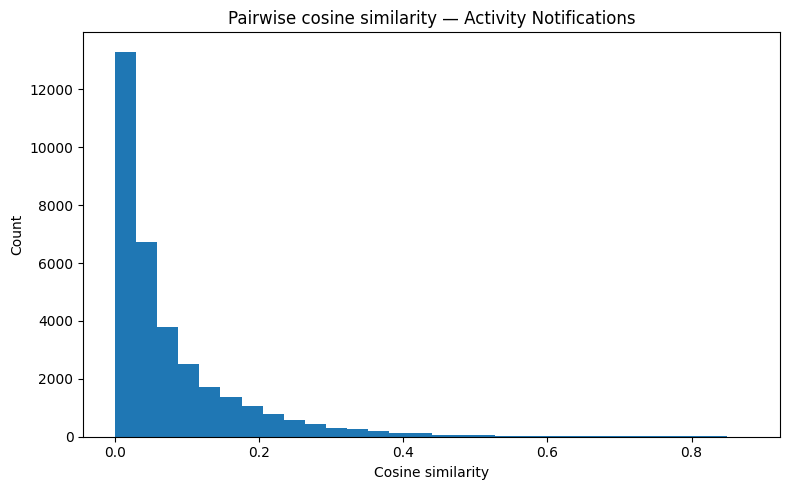

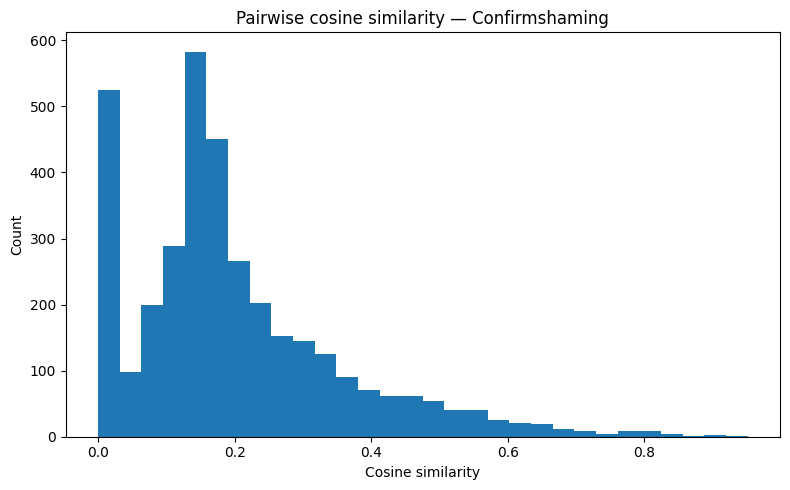

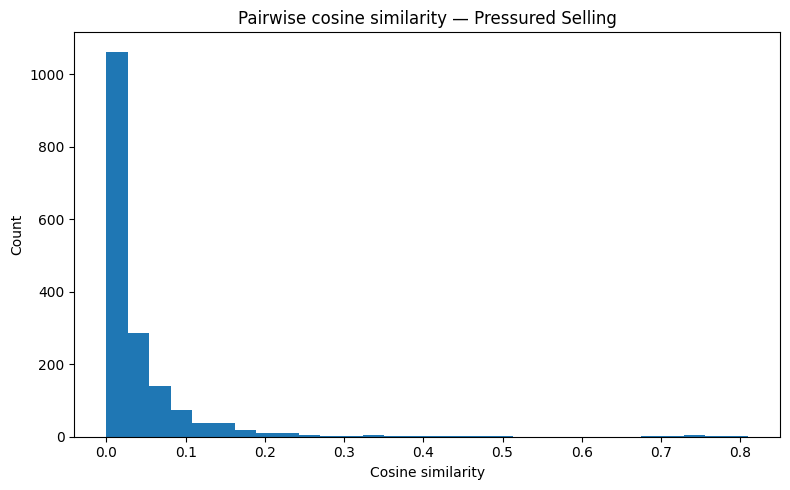

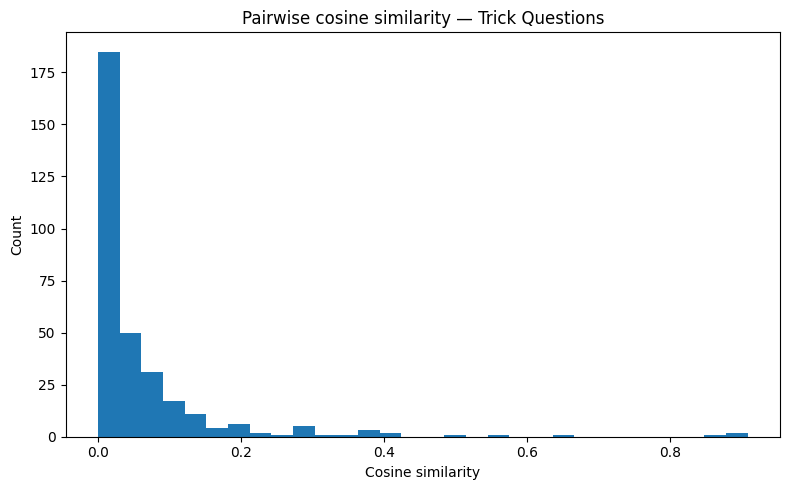

/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_15705/3740722634.py:42: RuntimeWarning: divide by zero encountered in matmul
  num = m2s(va @ vb.T)
/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_15705/3740722634.py:42: RuntimeWarning: overflow encountered in matmul
  num = m2s(va @ vb.T)
/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_15705/3740722634.py:42: RuntimeWarning: invalid value encountered in matmul
  num = m2s(va @ vb.T)
/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_15705/3740722634.py:43: RuntimeWarning: divide by zero encountered in matmul
  den = math.sqrt(m2s(va @ va.T)) * math.sqrt(m2s(vb @ vb.T))
/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_15705/3740722634.py:43: RuntimeWarning: overflow encountered in matmul
  den = math.sqrt(m2s(va @ va.T)) * math.sqrt(m2s(vb @ vb.T))
/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_15705/3740722634.py:43: RuntimeWarning: invalid value encountered in matmul
  den

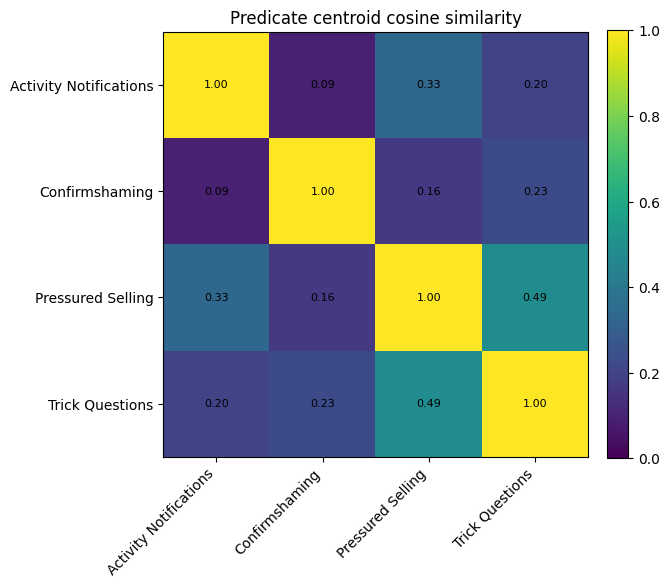

/Users/soyoung/404DNF_AI/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/soyoung/404DNF_AI/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/soyoung/404DNF_AI/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/soyoung/404DNF_AI/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/soyoung/404DNF_AI/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/soyoung/404DNF_AI/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normaliz

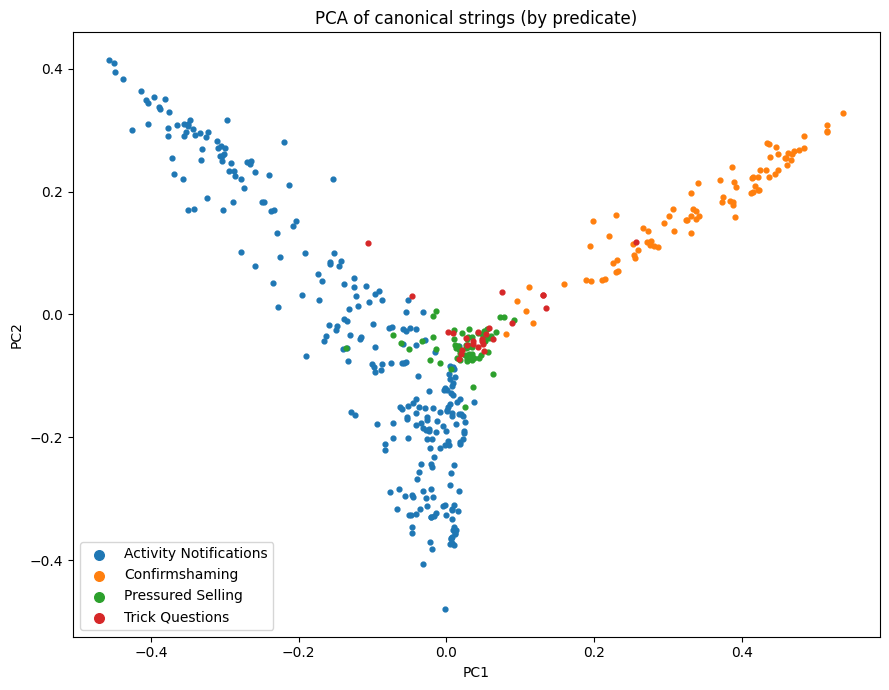

In [9]:
# %%
# 캐논 전체 TF-IDF (시각화 전용)
tfidf = TfidfVectorizer(analyzer=ANALYZER, ngram_range=(NGRAM_LO, NGRAM_HI), min_df=max(2, MIN_DF))
X_all  = tfidf.fit_transform(dedup_sorted["canonical_norm"])
labels = dedup_sorted["predicate"].values
pred_names = dedup_sorted["predicate"].unique().tolist()

# (1) predicate별 pairwise 코사인 분포 히스토그램
for p in pred_names:
    mask = (labels == p)
    idx = np.where(mask)[0]
    if len(idx) < 2:
        continue
    subX = X_all[idx]
    sims = (subX @ subX.T).toarray()
    triu = sims[np.triu_indices_from(sims, k=1)]
    if MAX_PAIRS_FOR_HIST and len(triu) > MAX_PAIRS_FOR_HIST:
        rng = np.random.default_rng(0)
        triu = rng.choice(triu, size=MAX_PAIRS_FOR_HIST, replace=False)
    plt.figure(figsize=(8,5))
    plt.hist(triu, bins=30)
    plt.title(f"Pairwise cosine similarity — {p}")
    plt.xlabel("Cosine similarity"); plt.ylabel("Count")
    plt.tight_layout()
    fname = f"hist_cosine_{p.replace(' ', '_')}.png"
    plt.savefig(out_dir/fname); plt.show()

# (2) predicate centroid 코사인 히트맵
centroids = {}
for p in pred_names:
    mask = (labels == p)
    centroids[p] = X_all[mask].mean(axis=0) if mask.sum() else None

n = len(pred_names)
M = np.zeros((n, n), dtype=float)
for i, a in enumerate(pred_names):
    for j, b in enumerate(pred_names):
        va, vb = centroids[a], centroids[b]
        if va is None or vb is None:
            M[i,j] = np.nan
        else:
            num = m2s(va @ vb.T)
            den = math.sqrt(m2s(va @ va.T)) * math.sqrt(m2s(vb @ vb.T))
            M[i,j] = num/den if den != 0 else np.nan

plt.figure(figsize=(1.2*n+2, 1.2*n+2))
im = plt.imshow(M, vmin=0, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(n), pred_names, rotation=45, ha="right")
plt.yticks(range(n), pred_names)
for i in range(n):
    for j in range(n):
        if not np.isnan(M[i,j]):
            plt.text(j, i, f"{M[i,j]:.2f}", ha="center", va="center", fontsize=8)
plt.title("Predicate centroid cosine similarity")
plt.tight_layout()
plt.savefig(out_dir/"centroid_heatmap.png"); plt.show()

# (3) PCA 산점도 (canonical 텍스트)
X_dense = X_all.toarray() if hasattr(X_all, "toarray") else X_all
pca = PCA(n_components=2, random_state=0)
XY = pca.fit_transform(X_dense)

plt.figure(figsize=(9,7))
for p in pred_names:
    mask = (labels == p)
    plt.scatter(XY[mask,0], XY[mask,1], s=12, label=p)
plt.legend(markerscale=2)
plt.title("PCA of canonical strings (by predicate)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(out_dir/"pca_canonical_by_predicate.png"); plt.show()


추가 결과 

In [12]:
# %% [markdown]
# Cell 8) Top-20 / Top terms 저장 + 간단 HTML 리포트

# %%
from pathlib import Path

# 안전 가드
if 'dedup_sorted' not in globals():
    raise RuntimeError("dedup_sorted 가 없습니다. 이전 셀들을 먼저 실행하세요.")

# ---------- Top 20 대표문장 by predicate ----------
pred_names = sorted(dedup_sorted["predicate"].dropna().unique().tolist())
top_rows = []
for p in pred_names:
    sub = (dedup_sorted[dedup_sorted["predicate"] == p]
              .sort_values("collapsed_count", ascending=False)
              .head(20))[["predicate","canonical_example","collapsed_count","num_variations"]]
    top_rows.append(sub)
top20_df = pd.concat(top_rows, ignore_index=True) if top_rows else pd.DataFrame(
    columns=["predicate","canonical_example","collapsed_count","num_variations"]
)
p_top20 = out_dir / "top20_canonical_by_predicate.csv"
top20_df.to_csv(p_top20, index=False)

# ---------- 상위 n-gram terms by predicate ----------
# (sparse .A 사용 금지 → get_feature_names_out 사용)
tfidf_terms = TfidfVectorizer(
    analyzer=ANALYZER,
    ngram_range=(NGRAM_LO, NGRAM_HI),
    min_df=max(2, MIN_DF)
)
X_terms = tfidf_terms.fit_transform(dedup_sorted["canonical_norm"])
terms = tfidf_terms.get_feature_names_out()

top_terms = []
pred_col_values = dedup_sorted["predicate"].values
for p in pred_names:
    mask = (pred_col_values == p)
    if mask.sum() == 0:
        continue
    # 각 term의 가중치(합) 계산
    weights = np.asarray(X_terms[mask].sum(axis=0)).ravel()
    top_idx = np.argsort(-weights)[:20]
    for rank, tidx in enumerate(top_idx, 1):
        top_terms.append({
            "Predicate": p,
            "rank": rank,
            "term": terms[tidx],
            "weight_sum": float(weights[tidx])
        })

p_terms = out_dir / "top_terms_by_predicate.csv"
pd.DataFrame(top_terms).to_csv(p_terms, index=False)

# ---------- 간단 HTML 리포트 ----------
# 히스토그램/히트맵/PCA 이미지는 이전 셀에서 저장된 파일명을 그대로 참고
html = f"""<!doctype html>
<html><head><meta charset="utf-8"><title>Similarity Report</title>
<style>
body{{font-family: Arial, sans-serif; margin:24px;}}
h2{{margin-top:28px;}}
table{{border-collapse:collapse; width:100%;}}
td,th{{border:1px solid #ccc; padding:6px 8px; font-size:14px;}}
img{{max-width:100%; height:auto;}}
</style>
</head><body>
<h1>Similarity & Deduplication Report</h1>
<p><b>Source:</b> {Path(DATA_CSV).name}</p>
<h2>Files</h2>
<ul>
<li>Predicate-level dedup: <code>template_predicate_dedup.csv</code></li>
<li>Original→Canonical mapping: <code>canonical_mapping.csv</code></li>
<li>Predicate summary: <code>dedup_summary_by_predicate.csv</code></li>
<li>Intra-predicate similarity stats: <code>predicate_intra_similarity_stats.csv</code></li>
<li>Centroid cosine (CSV): <code>predicate_centroid_cosine.csv</code></li>
<li>Global dedup: <code>global_dedup.csv</code></li>
<li>Cross-predicate similar pairs: <code>cross_predicate_similar_pairs.csv</code></li>
<li>Top 20 canonical strings: <code>{p_top20.name}</code></li>
<li>Top terms by predicate: <code>{p_terms.name}</code></li>
</ul>

<h2>Heatmap (Predicate Centroid Cosine)</h2>
<img src="centroid_heatmap.png" alt="centroid_heatmap.png"/>

<h2>PCA Scatter — Canonical strings by predicate</h2>
<img src="pca_canonical_by_predicate.png" alt="pca_canonical_by_predicate.png"/>

<h2>Histograms — Intra-predicate pair cosine</h2>
"""

# 히스토그램 이미지가 있을 때만 자동 포함
for p in pred_names:
    fname = f"hist_cosine_{p.replace(' ', '_')}.png"
    if (out_dir / fname).exists():
        html += f"<h3>{p}</h3><img src=\"{fname}\" alt=\"{fname}\"/>"

html += "</body></html>"
(out_dir / "report.html").write_text(html, encoding="utf-8")

print("Saved:")
print(" -", p_top20)
print(" -", p_terms)
print(" -", out_dir / "report.html")


Saved:
 - /Users/soyoung/404DNF_AI/output/similarity/top20_canonical_by_predicate.csv
 - /Users/soyoung/404DNF_AI/output/similarity/top_terms_by_predicate.csv
 - /Users/soyoung/404DNF_AI/output/similarity/report.html


In [13]:
# %% [markdown]
# Cell 9) Robust HTML Report (images embedded as Base64)

# %%
import base64, io, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

def img_to_base64(png_path: Path) -> str:
    with open(png_path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("ascii")
    return f"data:image/png;base64,{b64}"

def fig_to_base64(fig) -> str:
    bio = io.BytesIO()
    fig.savefig(bio, format="png", bbox_inches="tight")
    plt.close(fig)
    bio.seek(0)
    return f"data:image/png;base64,{base64.b64encode(bio.read()).decode('ascii')}"

# 안전 가드
if 'dedup_sorted' not in globals():
    raise RuntimeError("dedup_sorted 가 없습니다. 이전 셀들을 먼저 실행하세요.")
if 'DATA_CSV' not in globals() or 'out_dir' not in globals():
    raise RuntimeError("DATA_CSV / out_dir 설정이 없습니다. Cell 2를 확인하세요.")

# ===== 재계산(시각화용 TF-IDF) =====
ANALYZER   = ANALYZER if 'ANALYZER' in globals() else "char"
NGRAM_LO   = NGRAM_LO if 'NGRAM_LO' in globals() else 3
NGRAM_HI   = NGRAM_HI if 'NGRAM_HI' in globals() else 5
MIN_DF     = max(2, MIN_DF if 'MIN_DF' in globals() else 1)

tfidf_vis  = TfidfVectorizer(analyzer=ANALYZER, ngram_range=(NGRAM_LO, NGRAM_HI), min_df=MIN_DF)
X_all      = tfidf_vis.fit_transform(dedup_sorted["canonical_norm"])
labels     = dedup_sorted["predicate"].values
pred_names = sorted(pd.Series(labels).dropna().unique().tolist())

# ===== 1) Centroid heatmap (recreate + embed) =====
centroids = {}
for p in pred_names:
    mask = (labels == p)
    centroids[p] = X_all[mask].mean(axis=0) if mask.sum() else None

def m2s(m): return float(np.asarray(m).squeeze())
n = len(pred_names)
M = np.zeros((n, n), dtype=float)
for i, a in enumerate(pred_names):
    for j, b in enumerate(pred_names):
        va, vb = centroids[a], centroids[b]
        if va is None or vb is None:
            M[i,j] = np.nan
        else:
            num = m2s(va @ vb.T)
            den = math.sqrt(m2s(va @ va.T)) * math.sqrt(m2s(vb @ vb.T))
            M[i,j] = num/den if den != 0 else np.nan

fig = plt.figure(figsize=(1.2*n+2, 1.2*n+2))
im = plt.imshow(M, vmin=0, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(n), pred_names, rotation=45, ha="right")
plt.yticks(range(n), pred_names)
for i in range(n):
    for j in range(n):
        if not np.isnan(M[i,j]):
            plt.text(j, i, f"{M[i,j]:.2f}", ha="center", va="center", fontsize=8)
plt.title("Predicate centroid cosine similarity")
plt.tight_layout()
heatmap_b64 = fig_to_base64(fig)

# ===== 2) PCA scatter (embed) =====
Xd = X_all.toarray() if hasattr(X_all, "toarray") else X_all
pca = PCA(n_components=2, random_state=0)
XY = pca.fit_transform(Xd)
fig = plt.figure(figsize=(9,7))
for p in pred_names:
    mask = (labels == p)
    plt.scatter(XY[mask,0], XY[mask,1], s=12, label=p)
plt.legend(markerscale=2)
plt.title("PCA of canonical strings (by predicate)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
pca_b64 = fig_to_base64(fig)

# ===== 3) Per-predicate histograms (embed list) =====
hist_imgs = []
for p in pred_names:
    mask = (labels == p)
    idx = np.where(mask)[0]
    if len(idx) < 2:
        continue
    subX = X_all[idx]
    sims = (subX @ subX.T).toarray()
    triu = sims[np.triu_indices_from(sims, k=1)]
    fig = plt.figure(figsize=(8,5))
    plt.hist(triu, bins=30)
    plt.title(f"Pairwise cosine similarity — {p}")
    plt.xlabel("Cosine similarity"); plt.ylabel("Count")
    plt.tight_layout()
    hist_imgs.append((p, fig_to_base64(fig)))

# ===== 4) Tables to HTML =====
# 상단에서 저장해둔 파일이 없으면 만들어서 사용
p_top20 = out_dir / "top20_canonical_by_predicate.csv"
if not p_top20.exists():
    # 간단 생성
    tops = []
    for p in pred_names:
        sub = (dedup_sorted[dedup_sorted["predicate"] == p]
                  .sort_values("collapsed_count", ascending=False)
                  .head(20))[["predicate","canonical_example","collapsed_count","num_variations"]]
        tops.append(sub)
    pd.concat(tops, ignore_index=True).to_csv(p_top20, index=False)

p_terms = out_dir / "top_terms_by_predicate.csv"
if not p_terms.exists():
    tfidf_terms = TfidfVectorizer(analyzer=ANALYZER, ngram_range=(NGRAM_LO, NGRAM_HI), min_df=MIN_DF)
    X_terms = tfidf_terms.fit_transform(dedup_sorted["canonical_norm"])
    terms = tfidf_terms.get_feature_names_out()
    top_terms = []
    for p in pred_names:
        mask = (labels == p)
        if mask.sum() == 0: continue
        weights = np.asarray(X_terms[mask].sum(axis=0)).ravel()
        top_idx = np.argsort(-weights)[:20]
        for rank, tidx in enumerate(top_idx, 1):
            top_terms.append({"Predicate": p, "rank": rank, "term": terms[tidx], "weight_sum": float(weights[tidx])})
    pd.DataFrame(top_terms).to_csv(p_terms, index=False)

p_summary = out_dir / "dedup_summary_by_predicate.csv"
if not p_summary.exists():
    before_counts = df.groupby("predicate")["String"].nunique().rename("unique_before")
    after_counts  = dedup_sorted.groupby("predicate").size().rename("unique_after")
    collapsed_tot = dedup_sorted.groupby("predicate")["collapsed_count"].sum().rename("total_rows")
    summary = pd.concat([before_counts, after_counts, collapsed_tot], axis=1).fillna(0).astype(int)
    summary["reduction_%"] = ((1 - summary["unique_after"]/summary["unique_before"]) * 100).round(1)
    summary.to_csv(p_summary)

# 읽어서 미리보기 테이블 생성
def csv_to_html_table(path: Path, max_rows=50):
    if not path.exists():
        return "<i>(file not found)</i>"
    df_ = pd.read_csv(path)
    if len(df_) > max_rows:
        df_ = df_.head(max_rows)
    return df_.to_html(index=False, escape=False)

top20_html = csv_to_html_table(p_top20, 40)
terms_html = csv_to_html_table(p_terms, 40)
summary_html = csv_to_html_table(p_summary, 40)

# ===== 5) Compose HTML (embed images inline) =====
html = f"""<!doctype html>
<html><head><meta charset="utf-8"><title>Similarity Report</title>
<style>
body{{font-family: Arial, sans-serif; margin:24px;}}
h2{{margin-top:28px;}}
table{{border-collapse:collapse; width:100%;}}
td,th{{border:1px solid #ccc; padding:6px 8px; font-size:14px;}}
img{{max-width:100%; height:auto; border:1px solid #e5e7eb;}}
.code{{font-family: ui-monospace, SFMono-Regular, Menlo, Consolas, monospace; background:#f7f7f7; padding:2px 6px; border-radius:6px;}}
.small{{color:#555; font-size:13px;}}
</style>
</head><body>
<h1>Similarity & Deduplication Report</h1>
<p class="small"><b>Source:</b> {Path(DATA_CSV).name}</p>

<h2>Summary (per predicate)</h2>
{summary_html}

<h2>Heatmap — Predicate Centroid Cosine</h2>
<img src="{heatmap_b64}" alt="centroid heatmap"/>

<h2>PCA — Canonical strings by predicate</h2>
<img src="{pca_b64}" alt="pca scatter"/>

<h2>Histograms — Intra-predicate pair cosine</h2>
"""
for p, b64 in hist_imgs:
    html += f"<h3>{p}</h3><img src=\"{b64}\" alt=\"hist {p}\"/>"

html += f"""
<h2>Top 20 Canonical Strings per Predicate</h2>
{top20_html}

<h2>Top TF-IDF Terms per Predicate</h2>
{terms_html}

<p class="small">Report generated in notebook (images embedded as Base64 to avoid path issues).</p>
</body></html>
"""

report_path = out_dir / "report.html"
report_path.write_text(html, encoding="utf-8")
print("✅ Report written to:", report_path.resolve())


/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_15705/783230665.py:57: RuntimeWarning: divide by zero encountered in matmul
  num = m2s(va @ vb.T)
/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_15705/783230665.py:57: RuntimeWarning: overflow encountered in matmul
  num = m2s(va @ vb.T)
/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_15705/783230665.py:57: RuntimeWarning: invalid value encountered in matmul
  num = m2s(va @ vb.T)
/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_15705/783230665.py:58: RuntimeWarning: divide by zero encountered in matmul
  den = math.sqrt(m2s(va @ va.T)) * math.sqrt(m2s(vb @ vb.T))
/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_15705/783230665.py:58: RuntimeWarning: overflow encountered in matmul
  den = math.sqrt(m2s(va @ va.T)) * math.sqrt(m2s(vb @ vb.T))
/var/folders/hg/mhc8mjsj749cspxfbjl1tz8m0000gn/T/ipykernel_15705/783230665.py:58: RuntimeWarning: invalid value encountered in matmul
  den = mat

✅ Report written to: /Users/soyoung/404DNF_AI/output/similarity/report.html
